# Sabermetrics: The Air Quality Factor

In this Jupyter notebook I will explore the relationship between baseball performance and atmospheric air quality. The first step in this project is to import the multiple data sets with the goal of building a shared data frame so that the data can be easily compared using Pandas.


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline

#Set filepaths for baseball data and atmospheric data
team_path = "C:\Users\Nathan\Documents\GitHub\SabermetricsProject\Data\Teams.csv"

#epa_daily_path = "C:\Users\Nathan\Documents\GitHub\SabermetricsProject\Data\epa_hap_daily_summary.csv"
epa_yearly_path = "C:\Users\Nathan\Documents\GitHub\SabermetricsProject\Data\epa_air_quality_annual_summary.csv"


team_DF = pd.read_csv(team_path)
#epa_daily_DF = pd.read_csv(epa_daily_path)
epa_yearly_DF = pd.read_csv(epa_yearly_path)

#Edit dates to contain only year
#epa_yearly_DF["date_of_last_change"] = epa_yearly_DF["date_of_last_change"].str[:4]
#epa_yearly_DF.rename(columns={"date_of_last_change":"year"},inplace=True)

team_DF.rename(columns={"yearID":"year"},inplace=True)

#print("Original dataframe size = %s" %epa_yearly_DF.size)
#print("Memory usage for EPA yearly summary = %s" % epa_yearly_DF.memory_usage)


reading_types = epa_yearly_DF.parameter_name.unique()
print(len(reading_types))

print(reading_types)

1134
['Molybdenum PM10 STP' 'Sulfur dioxide' 'Phosphorus PM2.5 LC' ...,
 '123678-Hexachlorodibenzo-p-dioxin (TSP) STP'
 'Total octachlorodibenzo-p-dioxin (TSP) STP'
 '12378-Pentachlorodibenzofuran (TSP) STP']


Now that the data has been imported, the next  step is to clean the data by removing unneeded information and then  try to determine a shared key/column so that the dataframes can be merged. The epa readings contained in the dataframe were collected at a variety of cities within the US, many without any professional baseball team. There also may be cities that have atmospheric readings but no MLB team. Therefore I will identify the cities contained within both datasets and use these for my analysis. In addition, a new column within the team dataframe needs to be created that contains the city the team is located in. This can be derived by stripping the city name off the front of the team organization name.

Reduced dataframe size by 13353175


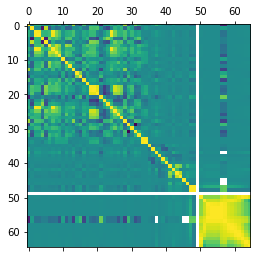

In [6]:
#Create a list of distinct cities where readings were collected
distinct_cities = epa_yearly_DF.city_name.unique()
MLB_cities = ["Baltimore","Boston","Chicago","Cleveland","Detroit","Houston","Kansas City","Anaheim",
             "Minneapolis","New York","Oakland","Seattle","St. Petersburg","Arlington","Phoenix",
             "Atlanta","Cincinnati","Denver","Los Angeles","Miami","Milwaukee","Philadelphia",
             "Pittsburgh","San Diego","San Francisco","St. Louis","Washington","St. Paul","Newark",]

shared_cities = [x for x in distinct_cities if x in MLB_cities]
epa_yearly_DF = epa_yearly_DF[epa_yearly_DF['city_name'].isin(shared_cities)]

print("Reduced dataframe size by %s" %epa_yearly_DF.size)

#Create a dictionary mapping teams to cities
team_cities = team_DF.name.unique()
team_to_city = {}
for words in team_cities:
    wordsList = words.split(" ")
    if wordsList[0]=="Kansas" or wordsList[0]=="San" or wordsList[0]=="Los" or wordsList[0]=="New" or wordsList[0]=="St.":
        team_to_city[words] = wordsList[0]+" "+wordsList[1]
    else:
        team_to_city[words] = wordsList[0]

#Add new city_name column to team dataframe to act as key for joining
team_DF["city_name"] = "default"

for index,row in team_DF.iterrows():
    if row["name"] in team_to_city:
        team_DF.set_value(index,"city_name",team_to_city[row["name"]])

merged_DF = pd.merge(team_DF,epa_yearly_DF,on="year")

plt.matshow(merged_DF.corr())

The correlation matrix above is way too large and is a mess. Therefore I will seperate the team columns into focus areas to try to make the important correlations more apparent.

In [7]:
team_col = ["W","H","2B","3B","ERA","FP","HR","SO","SF","E","teamID","year","city_name"]
stats_team_DF = team_DF[team_col]

merged_DF = pd.merge(stats_team_DF,epa_yearly_DF,on=["year","city_name"])

s = merged_DF.corr().unstack()
so = s.sort_values(kind="quicksort",ascending=False)

focus = ['W','ERA',"H","2B","3B","FP","HR","SO","E","SF"]
merged_DF.corr().filter(focus).drop(focus)

,W,ERA,H,2B,3B,FP,HR,SO,E,SF
year,0.103986,0.016280,0.079861,0.323241,-0.251888,0.559977,0.295951,0.737000,-0.510111,-0.203673
county_code,-0.028952,0.039561,0.015973,-0.009726,0.054882,0.047573,-0.039420,-0.113179,-0.032096,0.028857
site_num,0.046779,-0.114188,-0.009427,-0.059859,0.004963,0.054025,-0.097945,0.025515,-0.051175,-0.036956
parameter_code,0.081462,0.056529,0.108225,0.201229,-0.144662,0.202238,0.173891,0.235730,-0.182232,-0.036254
poc,0.097523,-0.067067,0.070567,0.120021,-0.054802,0.156079,0.062519,0.127196,-0.134670,-0.001641
latitude,0.000637,0.151073,0.111936,0.083421,-0.044560,0.018860,0.155795,-0.034152,-0.031942,0.060464
longitude,0.059715,0.116239,0.086355,0.168792,-0.062505,0.001550,0.206026,0.005677,-0.006929,0.061771
observation_count,-0.035513,-0.030333,-0.041880,-0.065306,0.034678,-0.066843,-0.073474,-0.042649,0.064627,-0.001886
observation_percent,0.037524,0.027401,0.068226,0.116529,-0.055774,0.097972,0.066071,0.070629,-0.077088,0.015384
valid_day_count,-0.020782,-0.038420,-0.024510,-0.044575,0.019473,-0.047955,-0.067689,-0.033792,0.052025,-0.006616


From the table above we can see that there are not any significant correlations between the datasets. In the comparison above all different atmospheric readings are being lumped together and treated as the same. With over 1000 unique reading types it does not really make sense to keep them lumped together. Lets see if there are any correlations between a few specific reading types.

In [9]:
sulfurdioxide_DF = merged_DF[merged_DF["parameter_name"] == "Sulfur dioxide"]

focus = ['W','ERA',"H","2B","3B","FP","HR","SO","E","SF"]
sulfurdioxide_DF.corr().filter(focus).drop(focus)

,W,ERA,H,2B,3B,FP,HR,SO,E,SF
year,0.109469,0.258738,0.186516,0.499711,-0.281702,0.621925,0.434604,0.756991,-0.539609,-0.127361
county_code,-0.000669,-0.023015,-0.041185,-0.067368,0.094357,0.084203,-0.070878,-0.016798,-0.061115,-0.061202
site_num,0.021713,-0.021419,0.020168,-0.003732,-0.047422,0.048280,-0.005615,0.057000,-0.042585,-0.017917
parameter_code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
poc,0.006296,-0.075081,-0.044872,-0.059233,-0.011359,0.028667,-0.042682,0.062222,-0.027063,-0.049556
latitude,-0.014117,0.211739,0.100779,0.075642,-0.038463,-0.051219,0.165280,-0.144869,0.025396,0.147260
longitude,0.087707,0.045141,0.078181,0.112335,-0.089095,-0.055710,0.126426,-0.093834,0.034318,0.144595
observation_count,0.017925,-0.026101,-0.008054,0.025688,-0.043257,0.100419,0.027575,0.142889,-0.083724,-0.051246
observation_percent,0.008425,0.104744,0.077451,0.123333,-0.076080,0.047431,0.041109,0.093668,-0.008353,0.021655
valid_day_count,0.013075,0.104908,0.083594,0.134422,-0.083268,0.048842,0.044147,0.102567,-0.008483,0.021646
